### **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import kmapper as km
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from mapping import MappingTDA
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import wilcoxon, ttest_rel, kruskal
from statsmodels.stats.weightstats import ttost_paired

In [2]:
# Set seed for reproducibility
seed_value = 42

# Ignore warnings
warnings.filterwarnings("ignore")

### **Load data**

In [3]:
data_path = 'your data directory here'

df = pd.read_csv(data_path + 'file_name.csv')
y = pd.read_csv(data_path + 'sex_labels.csv')
tiv = pd.read_csv(data_path + 'TIV.csv', header=None).rename(columns={0: 'TIV'})

x = pd.concat([df, tiv], axis=1)

# Print dimensions
print(f'Data shape: {df.shape}') # (n_samples, n_features)

Data shape: (1109, 52)


Split into train and test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed_value)

# Reset indices
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Print dimensions
print(f'X_train shape: {x_train.shape}')
print(f'X_test shape: {x_test.shape}')

X_train shape: (887, 53)
X_test shape: (222, 53)


In [5]:
train_tiv = x_train['TIV']
test_tiv = x_test['TIV']

# Drop TIV from the data
x_train.drop(columns='TIV', inplace=True)
x_test.drop(columns='TIV', inplace=True)

#### **Explanatory data analysis**

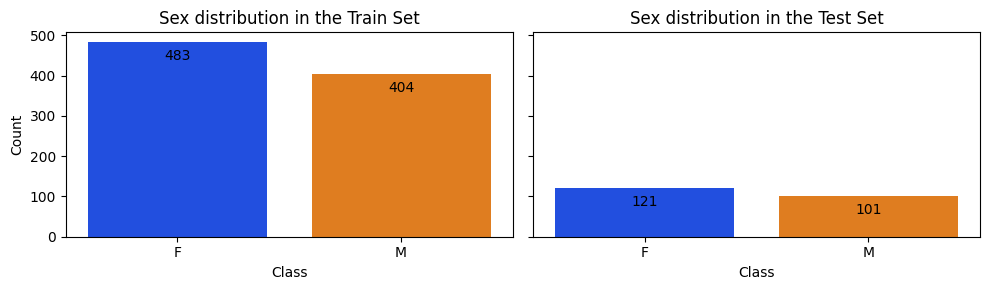

In [6]:
# Define a consistent color palette
unique_classes = sorted(set(y_train['Gender']).union(set(y_test['Gender'])))
palette = sns.color_palette("bright", len(unique_classes))
color_mapping = dict(zip(unique_classes, palette))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Plot the count plot for y_train
ax1 = sns.countplot(ax=axes[0], x=y_train['Gender'], palette=color_mapping.values())
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Sex distribution in the Train Set')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, -10), 
                 textcoords='offset points', color='black')

# Plot the count plot for y_test
ax2 = sns.countplot(ax=axes[1], x=y_test['Gender'], palette=color_mapping.values())
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Sex distribution in the Test Set')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, -10), 
                 textcoords='offset points', color='black')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### **Mapper (TDA)**

In [7]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper()


Choose Filter dimensionality reduction technique

In [8]:
projector = 'kpca'
if projector == 'pca':
    projector = PCA(n_components=2, random_state=seed_value)
elif projector == 'kpca':
    projector = KernelPCA(n_components=2, kernel='rbf', random_state=seed_value)
elif projector == 'isomap':
    projector = Isomap(n_components=2)

lens = projector.fit_transform(x_train)

Choose Cover parameters

In [9]:
cover = km.Cover(n_cubes=20, perc_overlap=0.6)

Choose Clustering technique

In [10]:
min_samples = 3
clusterer = DBSCAN(eps=32, min_samples=min_samples)

Create graph and convert it to NetworkX format

In [11]:
graph = mapper.map(lens, x_train,
                   cover=cover,
                   clusterer=clusterer)

nx_graph = km.adapter.to_nx(graph)

Mapping on data shaped (887, 52) using lens shaped (887, 2)

Creating 400 hypercubes.

Created 2420 edges and 269 nodes in 0:00:00.427770.


Visualize graph

In [ ]:
mapper.visualize(graph=graph, path_html='graph.html', color_function=np.array(train_tiv))

dyneugraph = dsr.DyNeuGraph(G=graph, y=np.array(train_tiv))
dyneugraph.visualize('graph_dyneusr.html', show=False)

### **TIV distribution across nodes**

In [13]:
graph_nodes = {name: attributes['membership'] for name, attributes in list(nx_graph.nodes(data=True))}

tiv_nodes = {}
for node, members in graph_nodes.items():
    tiv_distribution = []
    for member in members:
        tiv_distribution.append(train_tiv[member])

    node_id = int(node.split('cube')[1].split('_')[0]) 

    avg_tiv = np.mean(tiv_distribution)

    tiv_nodes[node_id] = avg_tiv

Distribution of average TIV in training set

In [14]:
train_membership = {}
for j in range(0, x_train.shape[0]):
    node_ = []
    for node, members in graph_nodes.items():
        node_id = int(node.split('cube')[1].split('_')[0])
        if j in members:
            node_.append(node_id)
    
    if len(node_) > 0:
        train_membership[j] = node_
    else:
        continue

In [15]:
train_tiv_distribution = {}
for idx, nodes in train_membership.items():
    tiv_in_nodes = []
    for node in nodes:
        tiv_in_nodes.append(tiv_nodes[node])

    train_tiv_distribution[idx] = [np.mean(tiv_in_nodes), train_tiv[idx]]

### **Mapping framework application**

In [16]:
mapping = MappingTDA(x_train, projector, cover)

In [17]:
graph_nodes_idx = [int(el_pca.split('cube')[1].split('_')[0]) for el_pca in list(nx_graph.nodes())]

In [18]:
test_mapped = {}
for i in range(0, x_test.shape[0]):
    subj = x_test.iloc[[i]]
    subj_projected = projector.transform(subj)

    hypercubes_idx, hypercubes, bins = mapping.mapping(subj_projected)

    nodes_idx = []
    for idx in hypercubes_idx:
        if idx in graph_nodes_idx:
            nodes_idx.append(idx)

    test_mapped[i] = nodes_idx

In [19]:
test_tiv_distribution = {}
for idx, nodes in test_mapped.items():
    tiv_in_nodes = []
    for node in nodes:
        tiv_in_nodes.append(tiv_nodes[node])

    test_tiv_distribution[idx] = [np.mean(tiv_in_nodes), test_tiv[idx]]

### **Statistical test**

**Estimated TIV**

In [20]:
train_tiv_pred = []
for idx, values in train_tiv_distribution.items():
    train_tiv_pred.append(values[0])

test_tiv_pred = []
for idx, values in test_tiv_distribution.items():
    test_tiv_pred.append(values[0])

train_tiv_pred = np.array(train_tiv_pred)
test_tiv_pred = np.array(test_tiv_pred)

**True TIV**

In [21]:
train_tiv_true = []
for idx, values in train_tiv_distribution.items():
    train_tiv_true.append(values[1])

test_tiv_true = []
for idx, values in test_tiv_distribution.items():
    test_tiv_true.append(values[1])

train_tiv_true = np.array(train_tiv_true)
test_tiv_true = np.array(test_tiv_true)

#### **Wilcoxon**

In [22]:
res_train = wilcoxon(train_tiv_true, train_tiv_pred)
res_test = wilcoxon(test_tiv_true, test_tiv_pred)

print(f'Wilcoxon test for Train Set: {res_train}')
print(f'Wilcoxon test for Test Set: {res_test}')

Wilcoxon test for Train Set: WilcoxonResult(statistic=191889.0, pvalue=0.5863967313588607)
Wilcoxon test for Test Set: WilcoxonResult(statistic=12120.0, pvalue=0.7889133116969538)


#### **Paired T-test**

In [23]:
res_train = ttest_rel(train_tiv_true, train_tiv_pred)
res_test = ttest_rel(test_tiv_true, test_tiv_pred)

print(f'T-Test for Train Set: {res_train}')
print(f'T-Test for Test Set: {res_test}')

T-Test for Train Set: TtestResult(statistic=-0.11411627891299446, pvalue=0.9091715300395586, df=884)
T-Test for Test Set: TtestResult(statistic=-0.5177655873635789, pvalue=0.6051397296154047, df=221)


#### **Kruskal**

In [24]:
stat_train, p_train = kruskal(train_tiv_true, train_tiv_pred)
stat_test, p_test = kruskal(test_tiv_true, test_tiv_pred)

print(f'Kruskal-Wallis test for Train Set: {stat_train}, p-value: {p_train}')
print(f'Kruskal-Wallis test for Test Set: {stat_test}, p-value: {p_test}')

Kruskal-Wallis test for Train Set: 0.5224999419245416, p-value: 0.4697772218108305
Kruskal-Wallis test for Test Set: 0.12086823021399255, p-value: 0.7280947250559551


#### **TOST: two one-sided T-test**

In [25]:
res_train = ttost_paired(train_tiv_true, train_tiv_pred, low=-0.1, upp=0.1)
res_test = ttost_paired(test_tiv_true, test_tiv_pred, low=-0.1, upp=0.1)

print(f'TOST for Train Set: {res_train}')
print(f'TOST for Test Set: {res_test}')

TOST for Train Set: (0.5338785381397262, (-0.08504745110282232, 0.5338785381397262, 884.0), (-0.14318510672316795, 0.4430883111711259, 884.0))
TOST for Test Set: (0.6925279555410067, (-0.5037425217409855, 0.6925279555410067, 221.0), (-0.5317886529861723, 0.2977032656033897, 221.0))
